Проект анализа стоимости недвижимости по таргетному столбцу last price, определяет от чего зависит окончательная цена недвижимости.


In [1]:
from pandas import *
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import stats
import requests

In [2]:
url="https://drive.google.com/file/d/1wIPbXwZHpsdfGZgj5GVoE7pHZkOPceyH/view?usp=drive_link"
df = read_csv('https://drive.usercontent.google.com/download?id={}&export=download&authuser=0&confirm=t'.format(url.split('/')[-2]))

In [3]:
df


,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest
0,13000000.0,108.00,3,2.70,16.0,51.0,8,NaN,False,False,25.00,NaN,18863.0,16028.0,1.0,482.0,2.0,755.0
1,3350000.0,40.40,1,NaN,11.0,18.6,1,NaN,False,False,11.00,2.0,12817.0,18603.0,0.0,NaN,0.0,NaN
2,5196000.0,56.00,2,NaN,5.0,34.3,4,NaN,False,False,8.30,0.0,21741.0,13933.0,1.0,90.0,2.0,574.0
3,64900000.0,159.00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,28098.0,6800.0,2.0,84.0,3.0,234.0
4,10000000.0,100.00,2,3.03,14.0,32.0,13,NaN,False,False,41.00,NaN,31856.0,8098.0,2.0,112.0,1.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9700000.0,133.81,3,3.70,5.0,73.3,3,NaN,False,False,13.83,NaN,24665.0,4232.0,1.0,796.0,3.0,381.0
23695,3100000.0,59.00,3,NaN,5.0,38.0,4,NaN,False,False,8.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23696,2500000.0,56.70,2,NaN,3.0,29.7,1,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,11475000.0,76.75,2,3.00,17.0,NaN,12,NaN,False,False,23.30,2.0,39140.0,10364.0,2.0,173.0,3.0,196.0


Для начала найду дубликаты и приведу типы

In [ ]:
print(df[df.duplicated(['last_price','floors_total','living_area','ponds_nearest','cityCenters_nearest','studio'])])

In [ ]:
forDel = df[df.duplicated(['last_price','floors_total','living_area','ponds_nearest','cityCenters_nearest','studio'])]
df=df.drop(forDel.index,axis=0)

In [ ]:
df.dtypes

Удаление Nan строк пока считаю не нужным, тк Nаn значения содержаться во многих не столь значимых столбцах, более того многие из них числовые и сведение к 0 очевидно исказить результат

In [ ]:
df['is_apartment']=df['is_apartment'].astype('bool')
df['total_area'] = df['total_area'].astype('int8')
df['rooms'] = df['rooms'].astype('int8')

При анализе сета, прихожу у выводу, что таргетом нужно взять столбец last_price и по нему смотреть коррреляции, однако он слабо отражает и коррелирует с остальными при рассмотрении более мелких кагорт, не имеет нормального рапределения и вообще слабо информативен, к примеру, можно взять 2 условных миллиона и купить на них элитную недвижимость размеров 200 кв метров в месте с прудами и лесами и остальными вполне коррелирующими признаками,  при этом можно взять условные 20 миллионов, и скупить на них одну "хрущевскую пятиэтажку" уровень и качество которой будет оставлять лучшего и последнее чем руководствоваться при выборе недвижимости, это например расстояние о центра и другие коррелирующие столбцы, хотя при этом ее стоимиость будет существенно выше элитной. Всвязи с этим необходимо ввести удельный, так сказать связаный признак. В реальной оценке недвижимости им является цена за кв. метр.

In [ ]:
df['last_price'].describe()


count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

<Axes: ylabel='Density'>

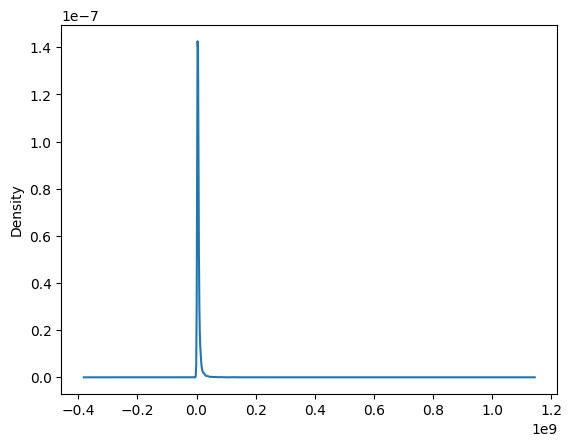

In [ ]:
df['last_price'].plot.density()

<Axes: >

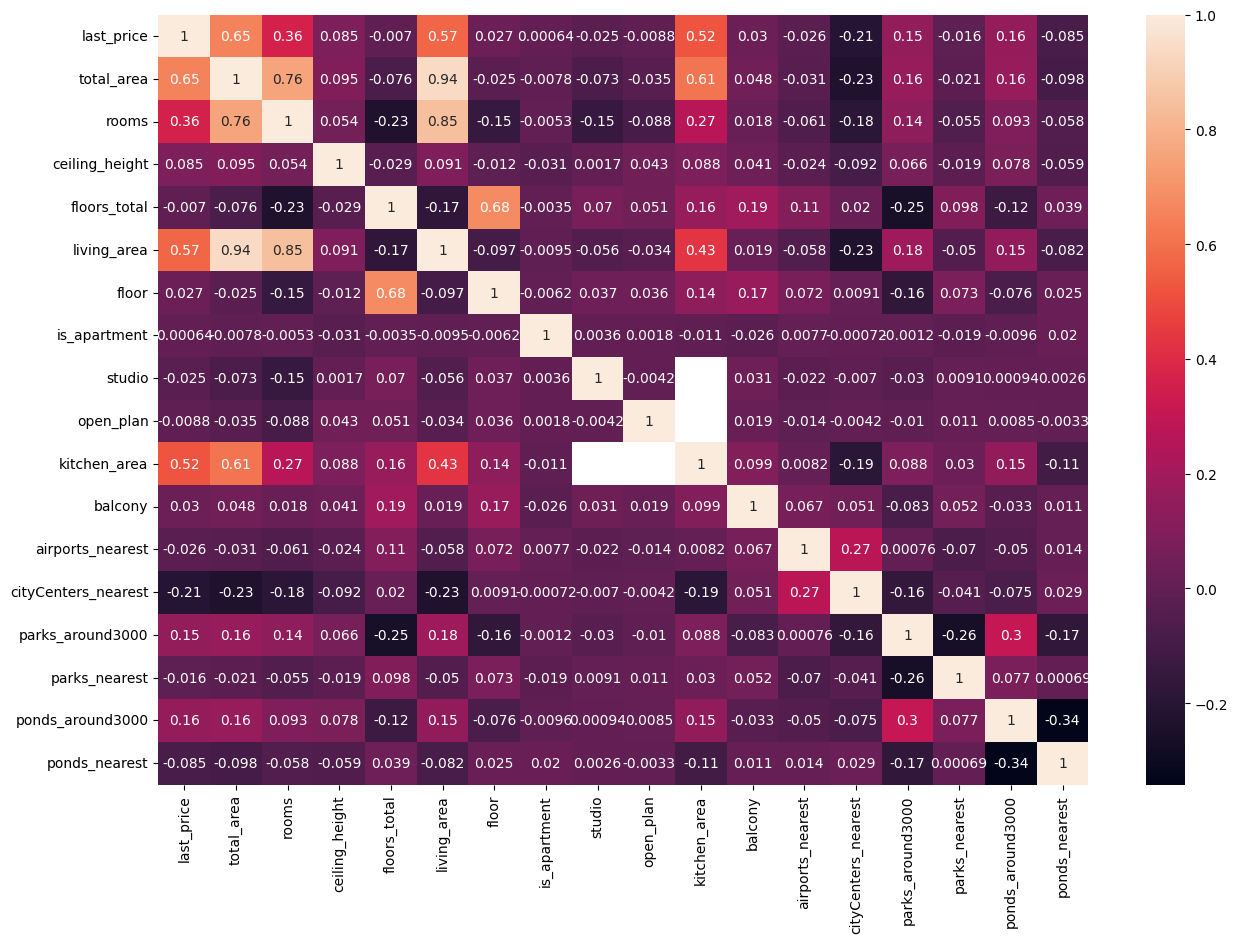

In [ ]:
plt.figure(figsize=(15,10))
sb.heatmap(df.corr(),annot = True)

На этом этапе ввожу столбец цена за кв метр и таргетный столбец рассматриваю в зависимости от распределения цены за метр

In [ ]:
df['Metros'] = df['last_price'] / df['total_area']

Одномерный анализ, в частности графики и матеметический анализ показывает об отсутствии нормального распределения данных, в связи с чем считаю правильным разделить анализ на когорты.

<Axes: ylabel='Density'>

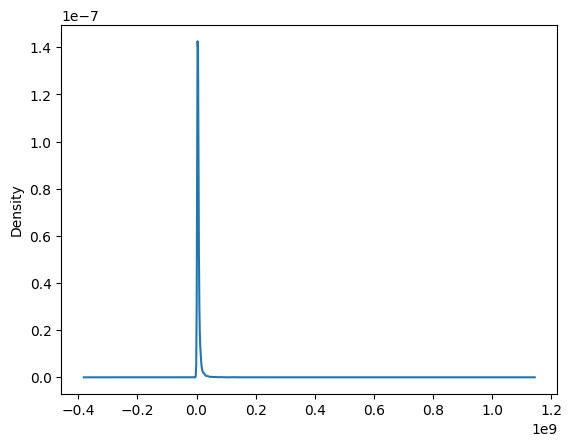

In [ ]:
df['last_price'].plot.density()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Писрона 58138.015065220454 0.0
Тест Шапиро-Уилка 0.25859010219573975 0.0
Ассиметрия 25.802641910150754
Эксцесс 1277.4127823287613


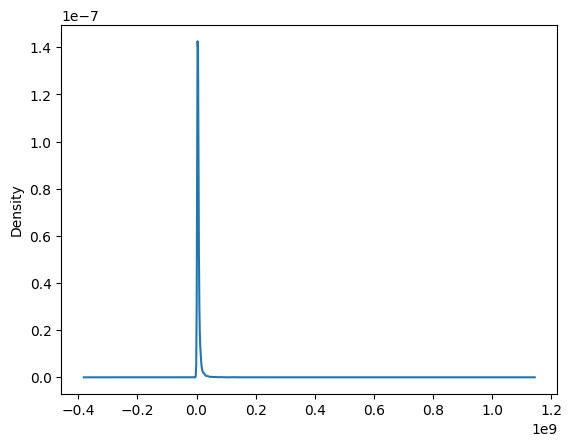

In [ ]:
df['last_price'].plot.density()
a,b= stats.shapiro(df['last_price'])
a2,b2 = stats.normaltest(df['last_price'])
print('Критерий Писрона',a2,b2)
print('Тест Шапиро-Уилка',a,b)
print("Ассиметрия",stats.skew(df['last_price'], bias = True))
print('Эксцесс',stats.kurtosis(df["last_price"],fisher=True))

Непосредственно в таргетном столбце данные разбросаны хаотично, при среднем значении 6,5 млн и значении в 75 квартиле 6,8 млн, максимальное значение достигает 760 млн.  

In [ ]:
df['last_price'].describe()
#df['last_price'].mean()


count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Естественно такая же ситуация обстоит со столбцом Metros.В связи этим и поставленной задачей разделяю таргетный столбец по квартилям стобца Metros и возможно, в зависимости от распределения данных, разделяю квартили на более мелкие кагорты.

<Axes: ylabel='Density'>

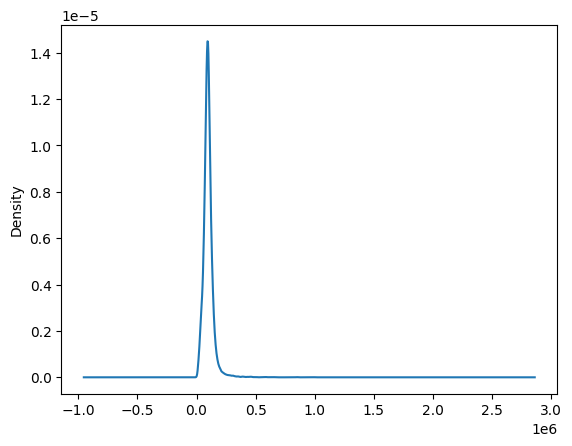

In [ ]:
df['Metros'].plot.density()


In [ ]:
a,b= stats.shapiro(df['last_price'])
a2,b2 = stats.normaltest(df['last_price'])
print('Критерий Писрона',a2,b2)
print('Тест Шапиро-Уилка',a,b)
print("Ассиметрия",stats.skew(df['last_price'], bias = True))
print('Эксцесс',stats.kurtosis(df["last_price"],fisher=True))

Критерий Писрона 58138.015065220454 0.0
Тест Шапиро-Уилка 0.25859010219573975 0.0
Ассиметрия 25.802641910150754
Эксцесс 1277.4127823287613


In [ ]:
df['Metros'].describe()
#df['Metros'].max()



count    2.369900e+04
mean     9.942166e+04
std      5.030680e+04
min      1.118349e+02
25%      7.658547e+04
50%      9.500000e+04
75%      1.142563e+05
max      1.907500e+06
Name: Metros, dtype: float64

In [ ]:
df['last_price'].describe()

<Axes: ylabel='Density'>

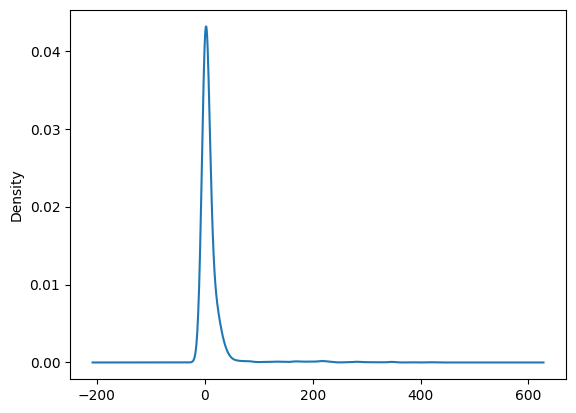

In [ ]:
df['total_area'].value_counts().plot.density()

In [ ]:
df['rooms'].value_counts(normalize=True)

In [ ]:
plt.figure(figsize=(15,10))
#sb.barplot(df1, x='rooms',y='last_price')

In [ ]:
df['ceiling_height'].plot.density()
#sb.countplot(df,x='ceiling_height')

In [ ]:
df['floors_total'].value_counts().plot(kind='pie',y='floors_total',autopct = "%")

In [ ]:
df['living_area'].value_counts()

In [ ]:
df['floor'].value_counts()

In [ ]:
df['is_apartment'].value_counts()

In [ ]:
df['studio'].value_counts()


In [ ]:
plt.figure(figsize=(15,10))
sb.barplot(df, x='studio',y='last_price')

In [ ]:
df['studio'].value_counts()


In [ ]:
df['kitchen_area'].value_counts()


In [ ]:
sb.lineplot(df1,x='kitchen_area',y='last_price')

In [ ]:
df['balcony'].value_counts()


In [ ]:
df['airports_nearest'].value_counts()


In [ ]:
df['cityCenters_nearest'].value_counts()


In [ ]:
df['parks_around3000'].value_counts()


In [ ]:
df['parks_nearest'].value_counts()


In [ ]:
df['ponds_around3000'].value_counts()


In [ ]:
plt.figure(figsize=(15,10))
#sb.barplot(df, x='ponds_around3000',y='last_price')

Здесь разделю DF на три квартиля 0-25, 25-75, 75-len

<Axes: ylabel='Density'>

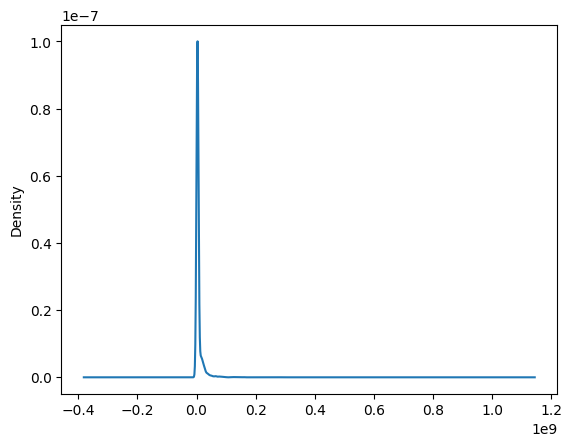

In [ ]:
df25= df[df['Metros']<77000]
df25['last_price'].plot.density()

Очевидно, равномерность распределения нарущается в диапазоне 0-45000 и 45000-len за кв метр, в связи с чем рассмотрю их как 2 отдельные кагорты.

<Axes: ylabel='Density'>

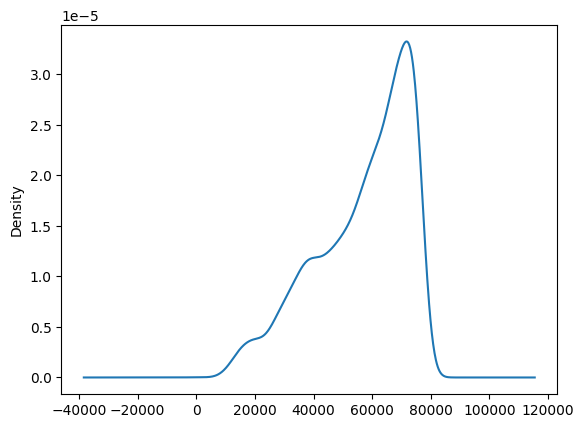

In [ ]:
df25['Metros'].plot.density()


In [ ]:
df0_45000 = df25[df25['Metros']<45000]
df0_45000

,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,Metros
3,64900000.0,-97,3,NaN,14.0,NaN,9,True,False,False,NaN,0.0,28098.0,6800.0,2.0,84.0,3.0,234.0,-669072.164948
35,15500000.0,-107,5,NaN,5.0,104.0,4,True,False,False,17.00,NaN,23670.0,3502.0,0.0,NaN,1.0,779.0,-144859.813084
37,1990000.0,45,2,2.5,5.0,NaN,1,True,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44222.222222
42,22000000.0,-95,4,2.8,4.0,80.9,2,False,False,False,17.60,5.0,35416.0,30605.0,2.0,47.0,1.0,907.0,-231578.947368
51,45000000.0,-95,3,3.2,8.0,38.0,4,True,False,False,50.00,NaN,32537.0,6589.0,0.0,NaN,3.0,99.0,-473684.210526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23683,2100000.0,62,4,2.5,5.0,45.5,3,True,False,False,5.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33870.967742
23684,21400000.0,-111,4,3.0,26.0,71.4,17,True,False,False,15.60,NaN,11827.0,11459.0,0.0,NaN,0.0,NaN,-192792.792793
23694,9700000.0,-123,3,3.7,5.0,73.3,3,True,False,False,13.83,NaN,24665.0,4232.0,1.0,796.0,3.0,381.0,-78861.788618
23696,2500000.0,56,2,NaN,3.0,29.7,1,True,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44642.857143


<ipython-input-53-00c8db75fc2c>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df0_45000.corr(),annot=True)


<Axes: >

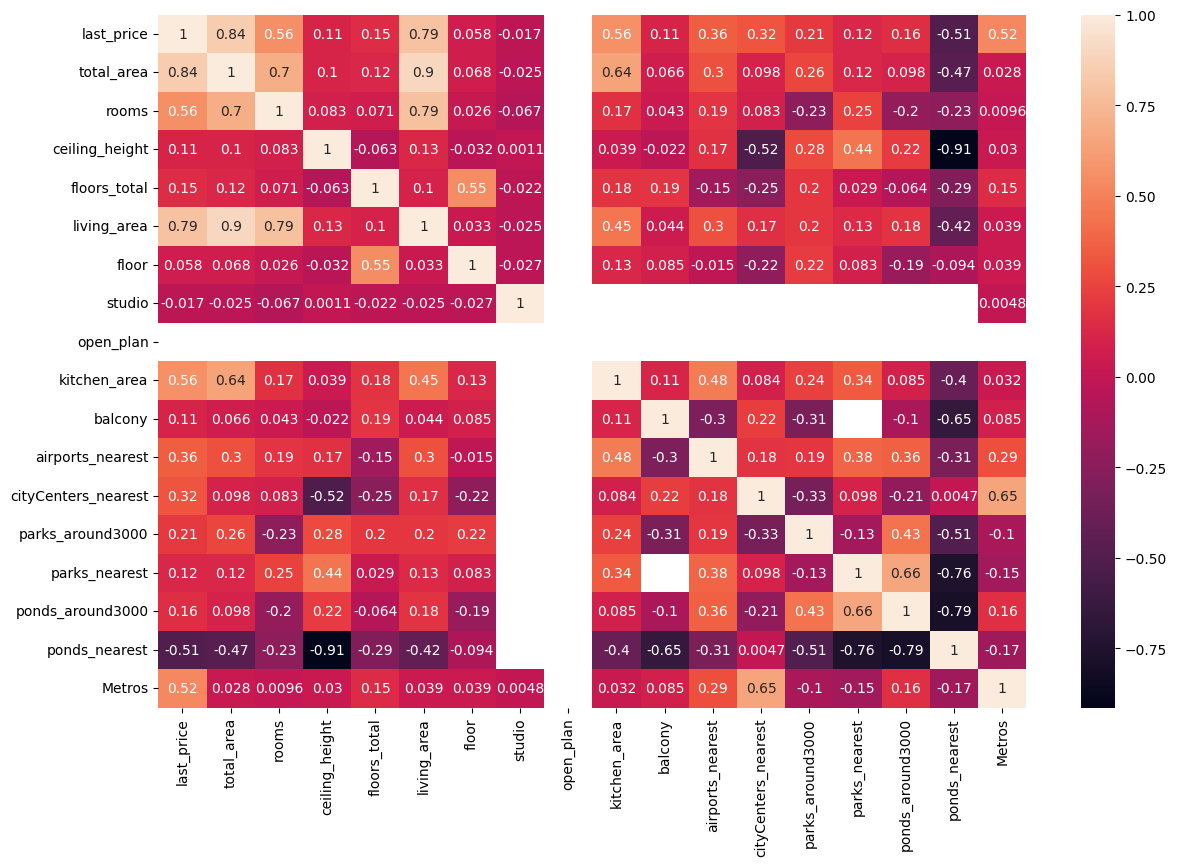

In [ ]:
plt.figure(figsize=(14,9))

sb.heatmap(df0_45000.corr(),annot=True)



In [ ]:
plt.figure(figsize=(14,9))
#sb.heatmap(df[(df["Metros"] > 77000)&(df['Metros'] <120000)].corr(),annot=True)

В диапазоне 0-45000 о корреляции цены и расстоянии до водоемов судить нельзя, тк недостаточно значений.


In [ ]:
sb.scatterplot (df0_45000, x='last_price',y='ponds_nearest')

In [ ]:
df0_45000['ponds_nearest'].value_counts()

427.0     18
153.0     13
802.0      8
198.0      8
454.0      7
          ..
1017.0     1
761.0      1
113.0      1
115.0      1
381.0      1
Name: ponds_nearest, Length: 317, dtype: int64

Очевидно, в диапазоне 0-45000 прямая корреляция цены от общей площади

<Axes: xlabel='last_price', ylabel='total_area'>

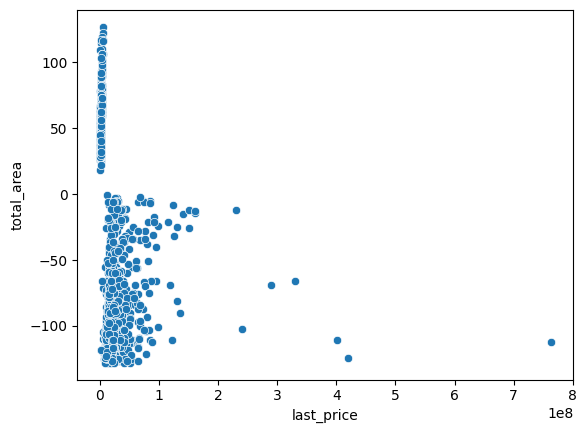

In [ ]:
sb.scatterplot (df0_45000, x='last_price',y='total_area')


Тоже самое происходит с жилой площадью, тк это зависимые параметры

<Axes: xlabel='last_price', ylabel='living_area'>

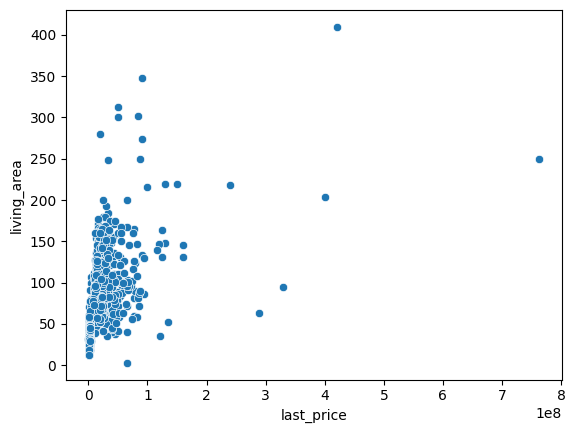

In [ ]:

sb.scatterplot (df0_45000, x='last_price',y='living_area')


в диапазоне 0-45000 колличество комнат плавно растет , однако в 6-ти комнатных квартирах цена резко возрастает.Рост цены начинается от значения 4390000.

<Axes: xlabel='rooms', ylabel='last_price'>

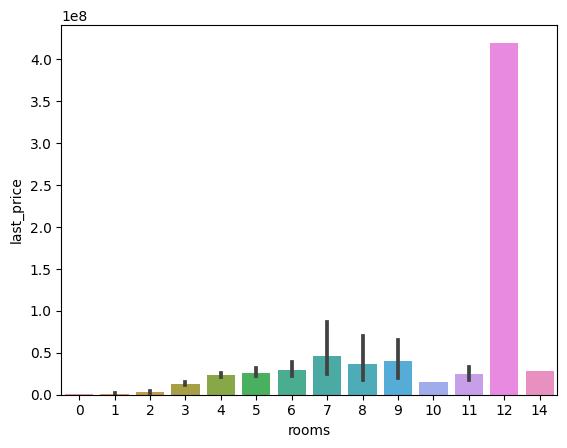

In [ ]:

sb.barplot (df0_45000, x='rooms',y='last_price')


In [ ]:
df0_45000[df0_45000['rooms']>=6]['last_price'].min()

4390000.0

В диапазоне 0-45000 площадь кухни растет с ростом цены


<Axes: xlabel='kitchen_area', ylabel='last_price'>

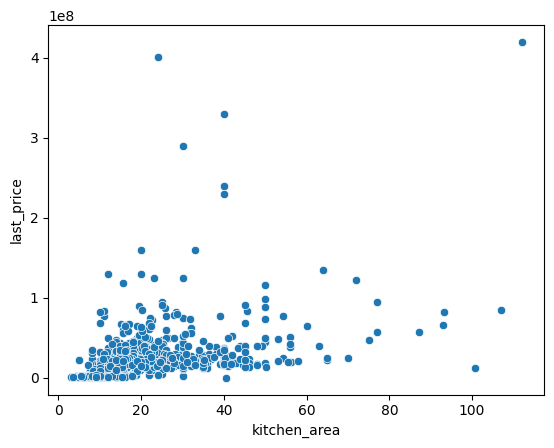

In [ ]:
sb.scatterplot (df0_45000, x='kitchen_area',y='last_price')


В диапазоне 0-45000 выбор этажа в пятиэтажных зданиях не выделяется, те в пятиэтажках покупатель не обращает внимание на этаж, также как и в 9 этажных зданиях покупатель выбирает верхние этажи начиная с 6-го. многоэтажные здания в этом диапазоне представлены мало.

<Axes: xlabel='floor', ylabel='floors_total'>

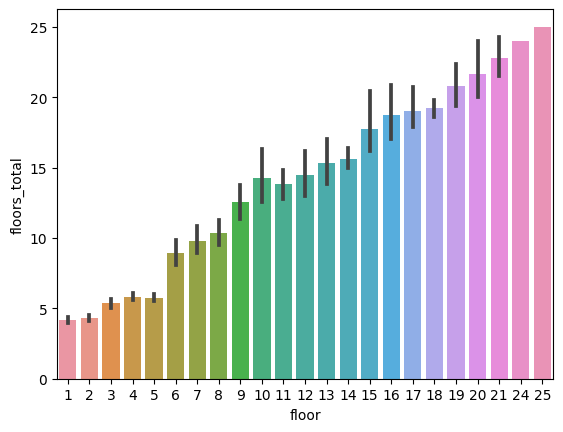

In [ ]:
sb.barplot (df0_45000, x='floor',y='floors_total')


В дианазоне 0-45000 студии стоят дешевле, однако их всего 1 квартира


<Axes: xlabel='studio', ylabel='last_price'>

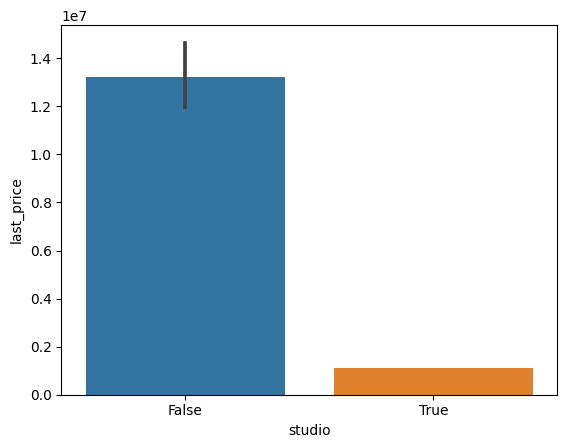

In [ ]:

sb.barplot (df0_45000, x='studio',y='last_price')


In [ ]:
df0_45000['studio'].value_counts(normalize=True)

В диапазоне 0-45000 нет квартир аппартаментов и квартир с открытой планировкой

В диапазоне 0-45000 колличество балконов не сильно зависит от этажности здания


/usr/local/lib/python3.10/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.10/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/usr/local/lib/python3.10/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.10/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.10/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encounter

<Axes: xlabel='floors_total', ylabel='balcony'>

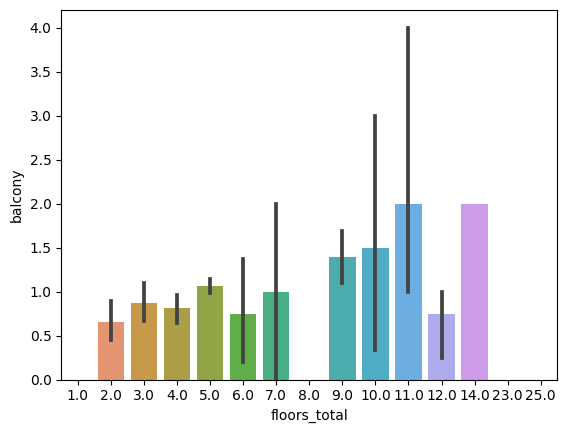

In [ ]:
sb.barplot (df0_45000, x='floors_total',y='balcony')


Следующий диапазон 45000-77000

In [ ]:
df45_77000= df25[(df25['Metros'] > 45000)&(df25['Metros']<77000)]
df45_77000

<ipython-input-83-4487ffe8872e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df45_77000.corr(),annot=True)


<Axes: >

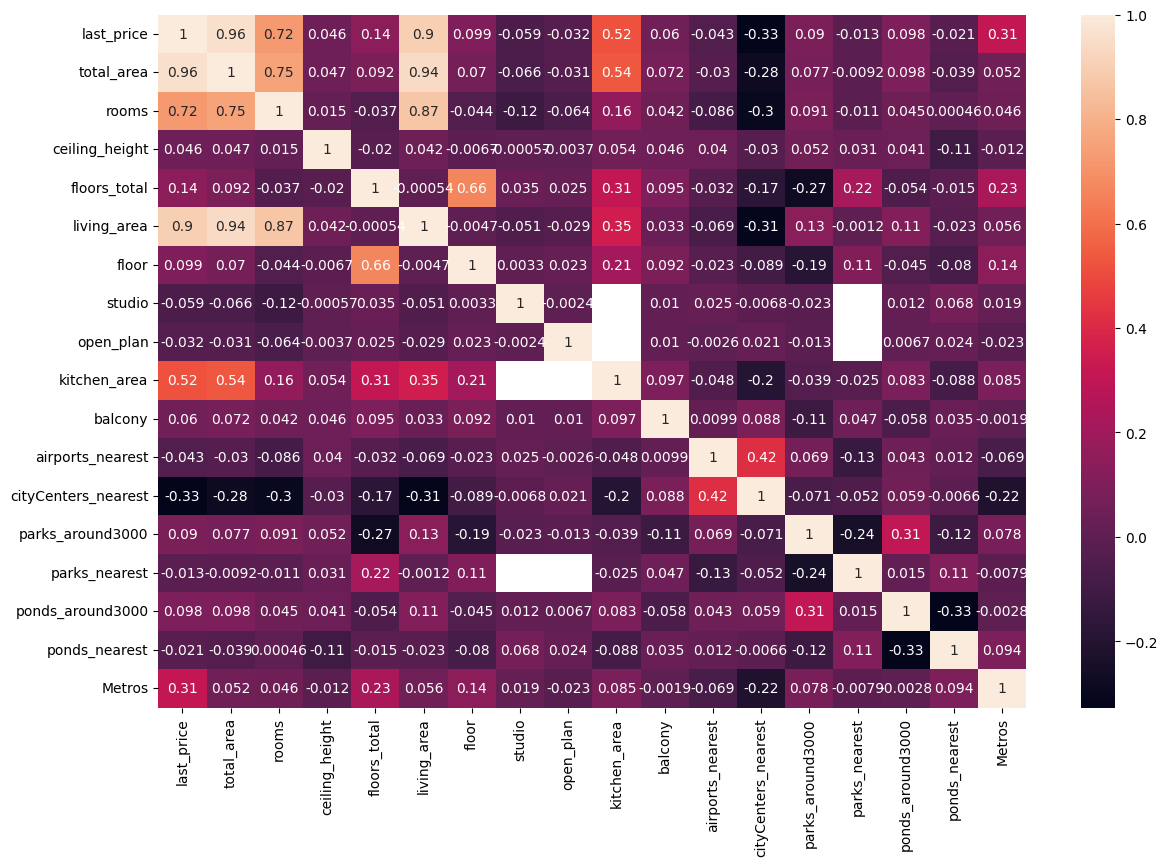

In [ ]:
plt.figure(figsize=(14,9))
sb.heatmap(df45_77000.corr(),annot=True)


в диапазоне 45-77000   до центра не сильно влияет на цену

In [ ]:
sb.scatterplot (df45_77000, x='cityCenters_nearest',y='last_price')


В диапазоне 45-77000 цена зависит от размера кухни

In [ ]:
sb.scatterplot (df45_77000, x='kitchen_area',y='last_price')


В диапазоне 45-77000 цена естественно зависит от общей площади, собственно как и от жилой

In [ ]:
sb.scatterplot (df45_77000, x='total_area',y='last_price')


В диапазоне 45-77000 цена стабильно растет в зависимомти от колличества комнат, максимальное количество комнат 9, значения 10 и 14, случайно попавшие в диапазон

<Axes: xlabel='rooms', ylabel='last_price'>

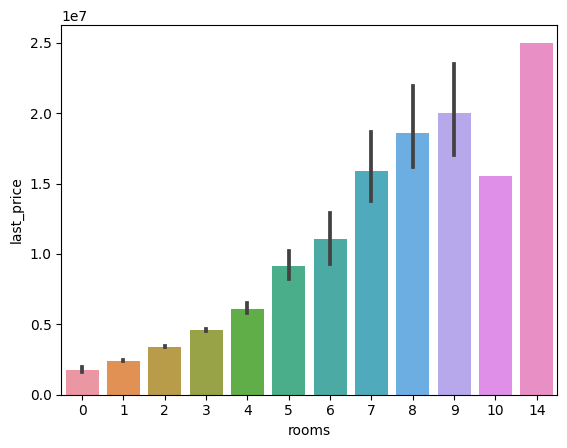

In [ ]:
sb.barplot (df45_77000, x='rooms',y='last_price')


В диапазоне 45-77000 тенденция с малоэтажными зданиями сохраняется в районе 5 и 9 этажей, однако после 9-го покупатели выбирают более  этажи начиная с 3\4 и выше.


<Axes: xlabel='floor', ylabel='floors_total'>

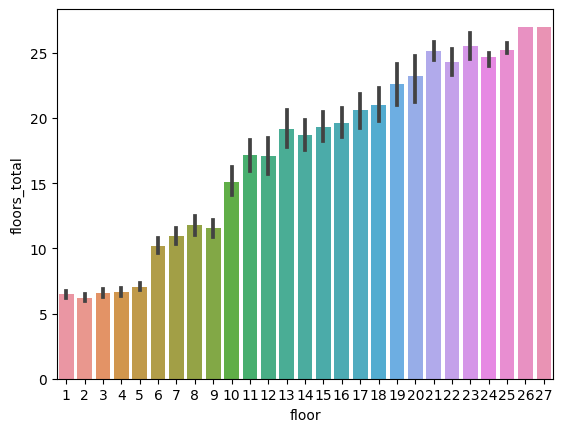

In [ ]:
sb.barplot (df45_77000, x='floor',y='floors_total')


В диапазоне 45-77000 разумеется количество комнат растет с увеличением общей площади.

<Axes: xlabel='rooms', ylabel='total_area'>

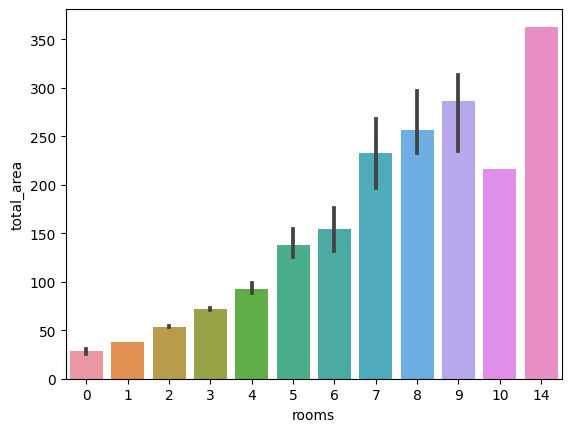

In [ ]:
sb.barplot (df45_77000, x='rooms',y='total_area')


Следующий квартиль 25-75

In [ ]:
df25_75= df[(df['Metros'] > 77000)&(df['Metros']<114000)]
df25_75

<Axes: ylabel='Density'>

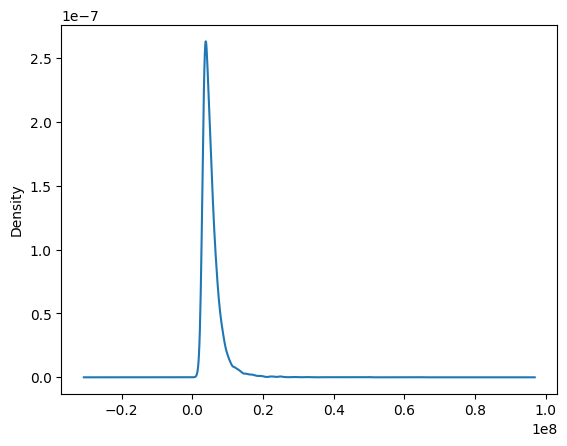

In [ ]:
df25_75['last_price'].plot.density()

Согласно графику плотности распределения,  25,75 квартиль принемаю как один интервал

<Axes: ylabel='Density'>

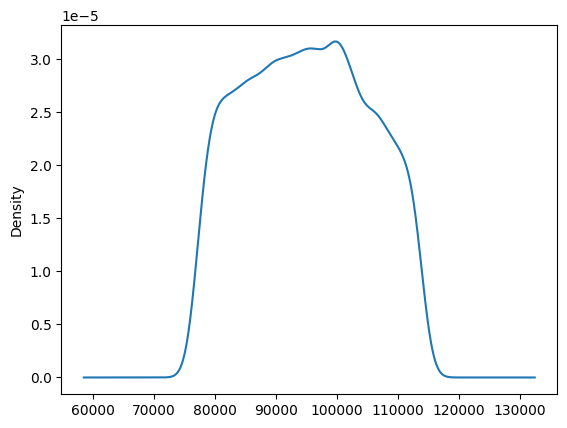

In [ ]:
df25_75['Metros'].plot.density()



<ipython-input-117-200332e92b66>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df25_75.corr(),annot=True)


<Axes: >

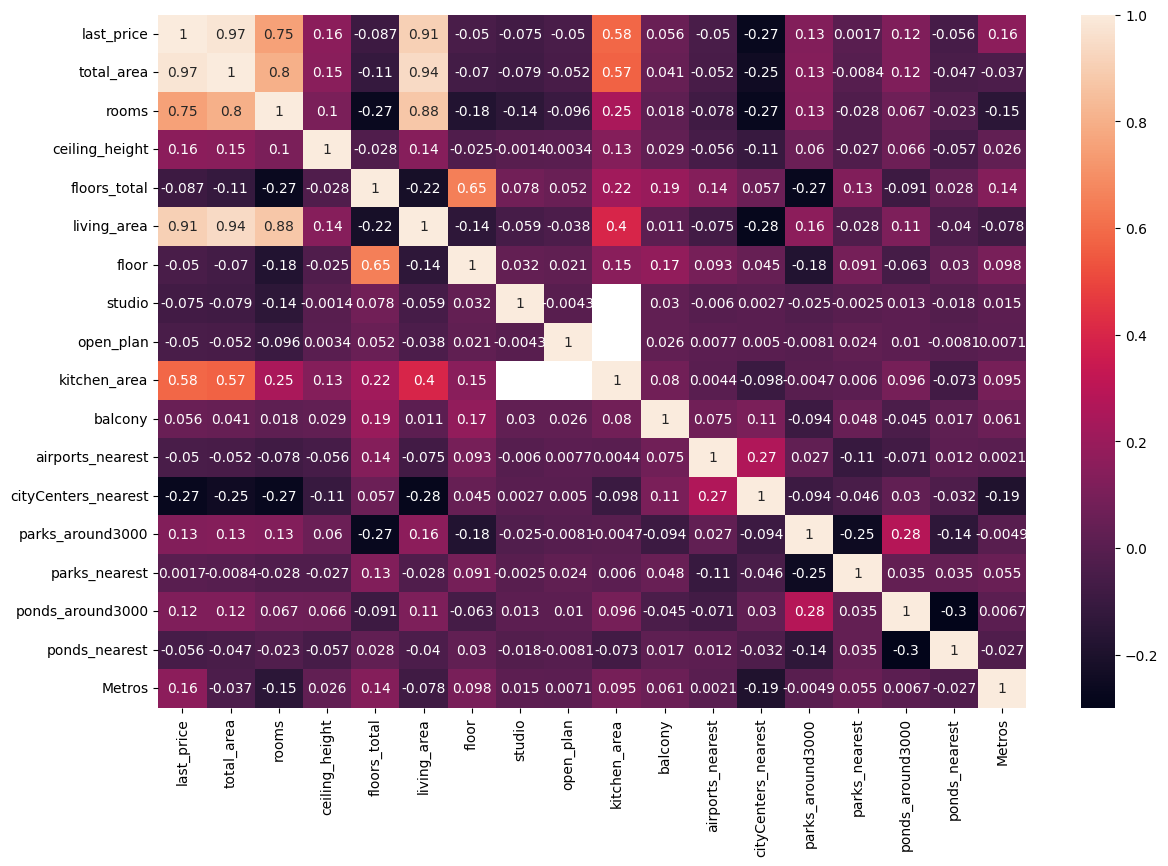

In [ ]:
plt.figure(figsize=(14,9))
sb.heatmap(df25_75.corr(),annot=True)

В квартиле 25,75 цена сильно зависит от жилой площади

In [ ]:
sb.scatterplot (df25_75, x='last_price',y='living_area')


Расстояние от центра, также не влияет на цену

<Axes: xlabel='last_price', ylabel='cityCenters_nearest'>

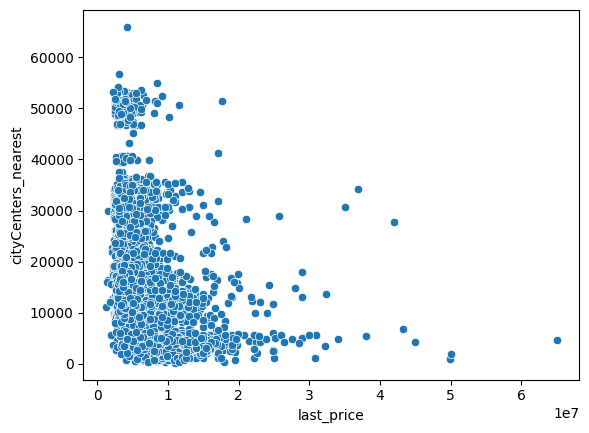

In [ ]:
sb.scatterplot (df25_75, x='last_price',y='cityCenters_nearest')


В 25,75 квартиле цена растет до коллличества комнат равное 7, далеее меняется слабо, обЪекты количсетвом комнат больше 9 попали случайно

Размер кухни растет с повышением цены

<Axes: xlabel='kitchen_area', ylabel='last_price'>

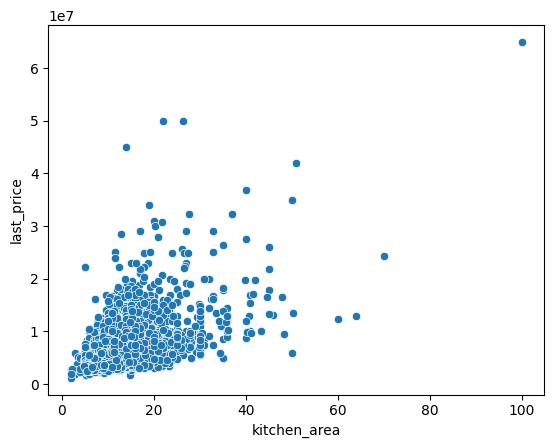

In [ ]:
sb.scatterplot (df25_75, x='kitchen_area',y='last_price')


Как не странно, но в 25,75 квартиле с увеличением колличества парков вокруг уменьшается этажность зданий

<Axes: xlabel='parks_around3000', ylabel='floors_total'>

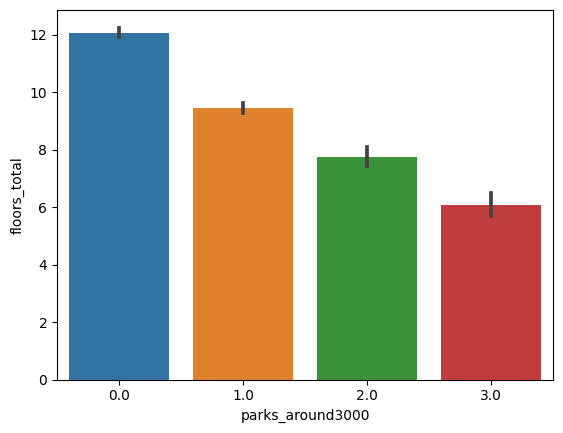

In [ ]:
sb.barplot (df25_75, x='parks_around3000',y='floors_total')


в 25,75 квартиле, с ростом этажности покупатель отдает предпочтение более высоким этажам

<Axes: xlabel='floor', ylabel='floors_total'>

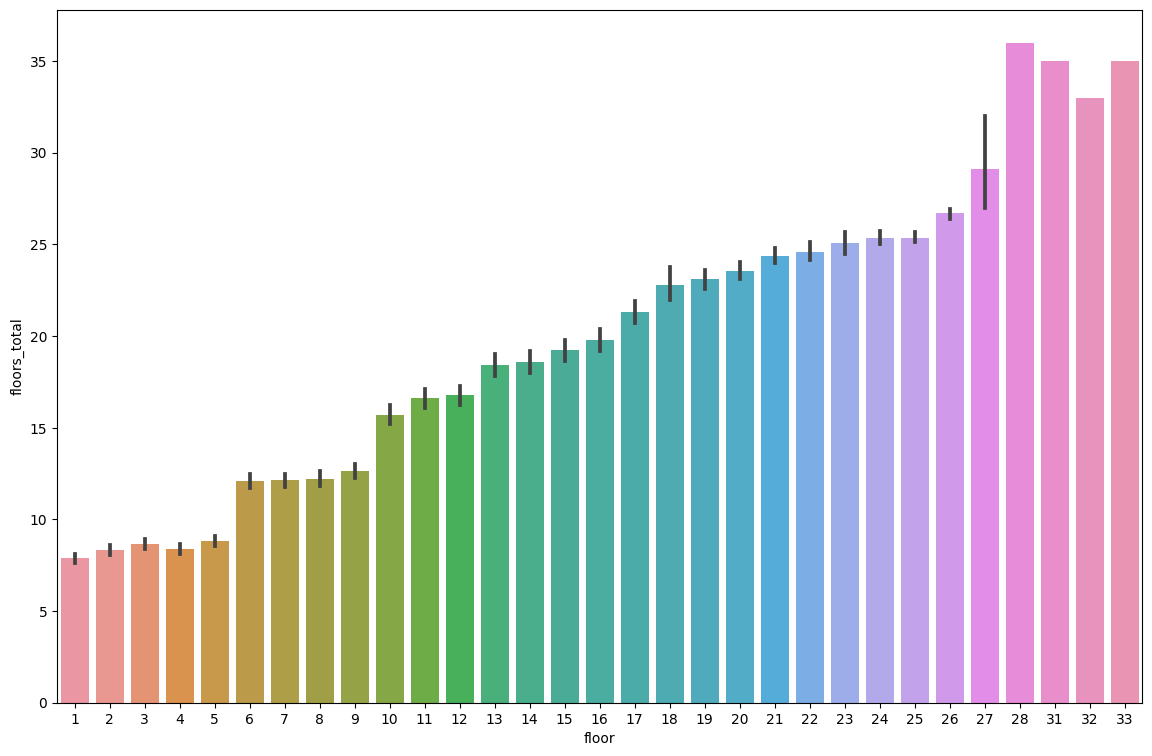

In [ ]:
plt.figure(figsize=(14,9))

sb.barplot (df25_75, x='floor',y='floors_total')



Студии в диапазоне стоят меньше, но их колличество менее 1%

<Axes: xlabel='studio', ylabel='last_price'>

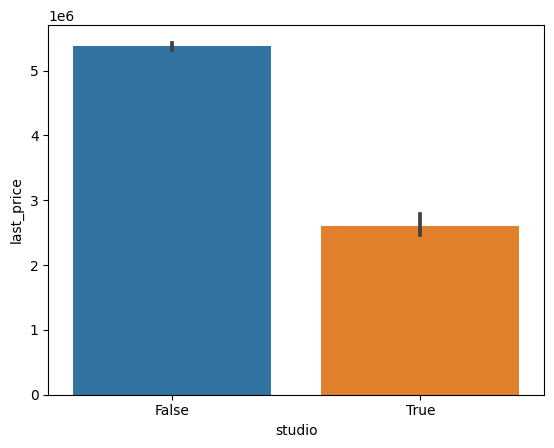

In [ ]:
sb.barplot (df25_75, x='studio',y='last_price')


In [ ]:
df25_75['studio'].value_counts(normalize=True)

False    0.993761
True     0.006239
Name: studio, dtype: float64

квартиры со свободной планировкой в диапазоне стоят меньше, но их колличество менее 1%


<Axes: xlabel='open_plan', ylabel='last_price'>

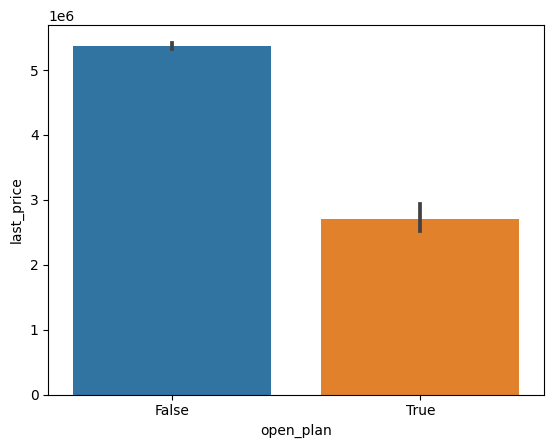

In [ ]:
sb.barplot (df25_75, x='open_plan',y='last_price')


In [ ]:
df25_75['open_plan'].value_counts(normalize=True)


False    0.997009
True     0.002991
Name: open_plan, dtype: float64

Следующий диапазон 114000 - len или четвертый квартель

In [ ]:
df114H = df[df['Metros']> 114000]
df114H

Согласно гистограмме, стоит разбить диапазон на 2 когорты, 114000-300000 и 300000-len

<Axes: xlabel='Metros', ylabel='Count'>

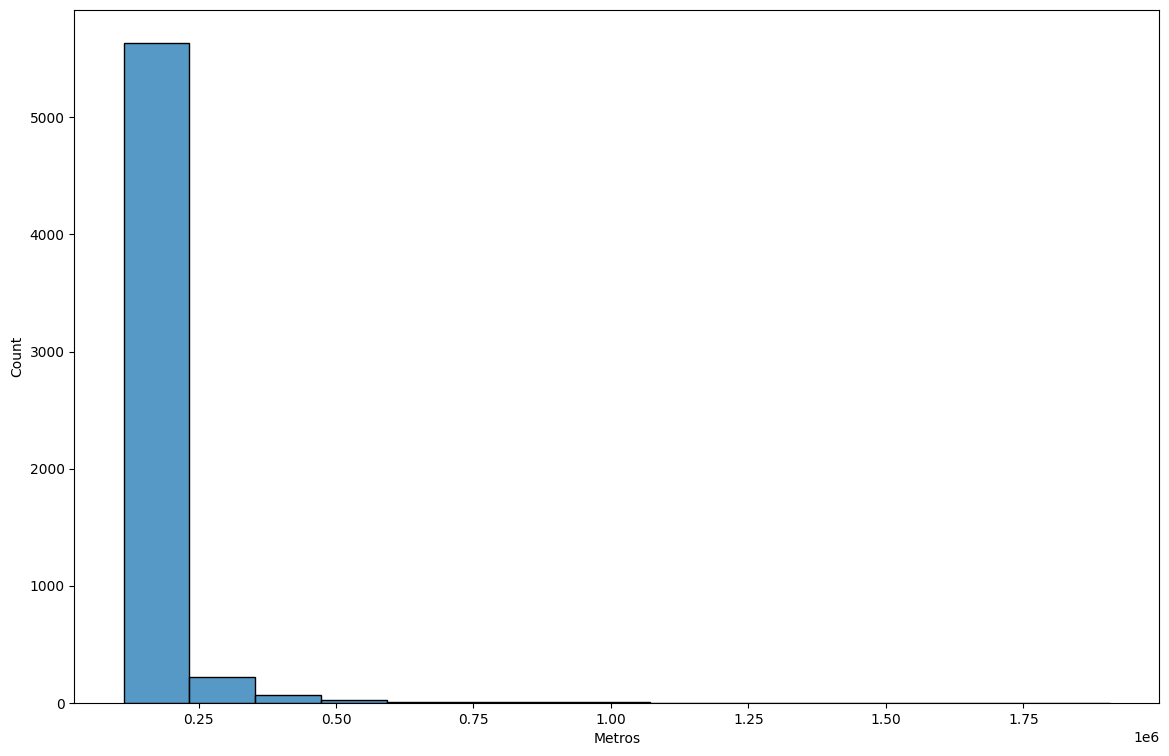

In [ ]:
plt.figure(figsize=(14,9))

sb.histplot(df114H, x='Metros',bins=15)

In [ ]:
df114_300000 = df114H[df114H['Metros']<300000]
df114_300000

,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,Metros
0,13000000.0,108.00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,18863.0,16028.0,1.0,482.0,2.0,755.0,120370.370370
10,5050000.0,39.60,1,2.67,12.0,20.3,3,NaN,False,False,8.5,NaN,38357.0,13878.0,1.0,310.0,2.0,553.0,127525.252525
14,4400000.0,36.00,1,NaN,6.0,17.0,1,NaN,False,False,8.0,0.0,20782.0,30759.0,0.0,NaN,1.0,96.0,122222.222222
15,4650000.0,39.00,1,NaN,14.0,20.5,5,NaN,False,False,7.6,1.0,12900.0,14259.0,1.0,590.0,1.0,296.0,119230.769231
17,4180000.0,36.00,1,NaN,17.0,16.5,7,NaN,False,False,11.0,1.0,33564.0,14616.0,0.0,NaN,1.0,859.0,116111.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23673,3100000.0,23.00,1,2.80,9.0,12.6,1,NaN,False,False,5.0,2.0,11813.0,11881.0,1.0,262.0,1.0,442.0,134782.608696
23681,5250000.0,43.00,2,2.50,5.0,29.0,2,NaN,False,False,6.0,NaN,28323.0,7262.0,1.0,497.0,2.0,660.0,122093.023256
23684,21400000.0,145.00,4,3.00,26.0,71.4,17,NaN,False,False,15.6,NaN,11827.0,11459.0,0.0,NaN,0.0,NaN,147586.206897
23691,9470000.0,72.90,2,2.75,25.0,40.3,7,NaN,False,False,10.6,1.0,19424.0,4489.0,0.0,NaN,1.0,806.0,129903.978052


<ipython-input-141-d32a212c8494>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df114_300000.corr(),annot=True)


<Axes: >

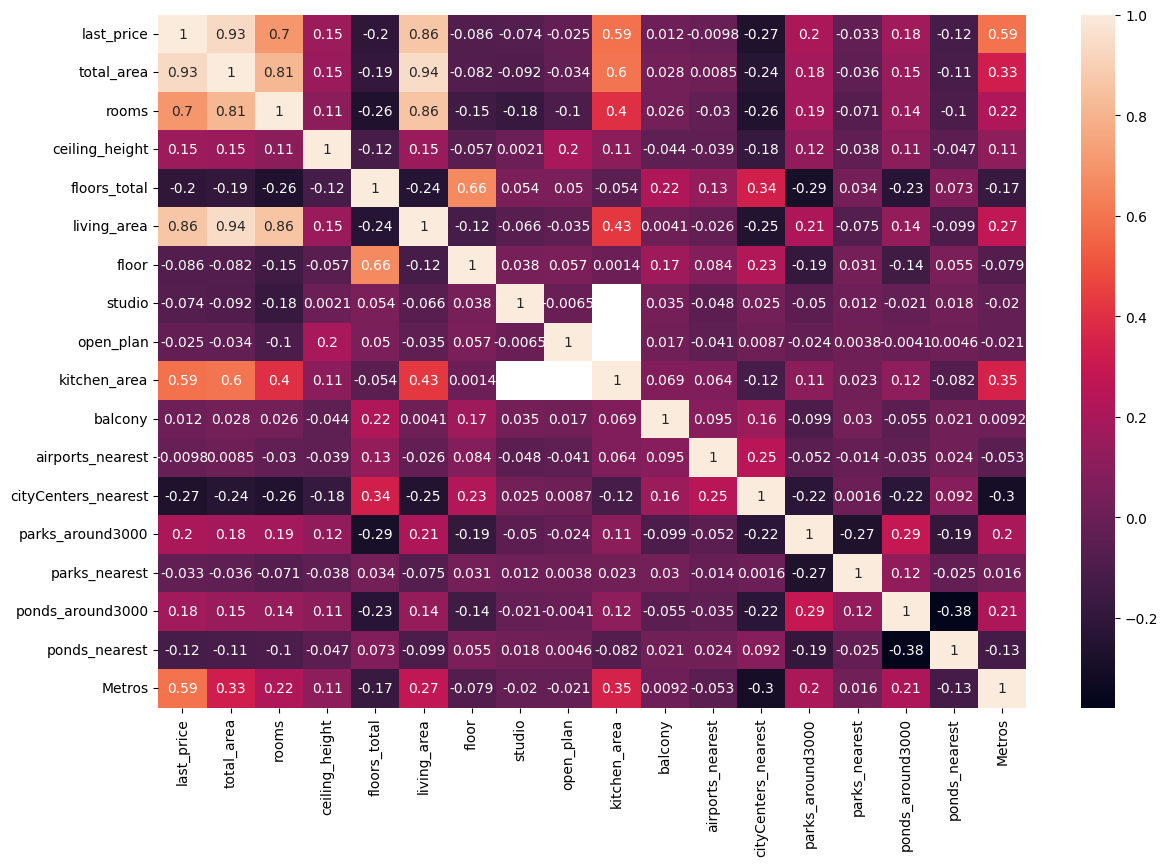

In [ ]:
plt.figure(figsize=(14,9))
sb.heatmap(df114_300000.corr(),annot=True)

In [ ]:
sb.scatterplot (df114_300000, x='last_price',y='cityCenters_nearest')


В диапазоне цена зависит от общей и жилой площади.

In [ ]:
sb.scatterplot (df114_300000, x='last_price',y='total_area')


в Диапазоне площадь кухни зависит от цены

In [ ]:
sb.scatterplot (df114_300000, x='kitchen_area',y='last_price')


В диапазоне с повышением кооличества парков уменьшается этажность здания

In [ ]:
sb.barplot (df114_300000, x='parks_around3000',y='floors_total')


В диапазоне с увеличением этажности, выбор падает на более высокие этажи, однако 5-ти этажные здания  теперь отсутствуют

In [ ]:
plt.figure(figsize=(14,9))

sb.barplot (df114_300000, x='floor',y='floors_total')

Студии стоят дешевле, однако их колличество 1%

In [ ]:
sb.barplot (df114_300000, x='studio',y='last_price')


In [ ]:
df114_300000['studio'].value_counts(normalize=True)

Квартиры с открытой планировкой стоят дешевле, однако их менее 1%

In [ ]:
sb.barplot (df114_300000, x='open_plan',y='last_price')


In [ ]:
df114_300000['open_plan'].value_counts(normalize=True)


На этом этапе явной зависи этажности от наличия балконов

In [ ]:
plt.figure(figsize=(14,9))

sb.barplot (df114_300000, x='floors_total',y='balcony')



Следующий диапазон 300000-len

In [ ]:
df300000H = df114H[df114H['Metros']>300000]
df300000H

,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,Metros
3,64900000.0,159.0,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,28098.0,6800.0,2.0,84.0,3.0,234.0,4.081761e+05
155,96000000.0,317.0,4,3.50,3.0,183.0,3,NaN,False,False,NaN,1.0,22673.0,1771.0,2.0,508.0,3.0,366.0,3.028391e+05
282,37000000.0,115.0,2,NaN,5.0,65.0,2,NaN,False,False,14.0,NaN,23537.0,1995.0,2.0,121.0,2.0,663.0,3.217391e+05
492,95000000.0,216.0,4,3.00,5.0,86.0,4,NaN,False,False,77.0,NaN,21740.0,436.0,2.0,138.0,3.0,620.0,4.398148e+05
509,90000000.0,225.0,6,NaN,4.0,134.0,2,NaN,False,False,19.5,2.0,32864.0,5720.0,0.0,NaN,2.0,519.0,4.000000e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22804,81960000.0,205.0,4,3.20,9.0,108.0,3,NaN,False,False,10.0,NaN,21946.0,2242.0,1.0,679.0,1.0,227.0,3.998049e+05
22831,289238400.0,187.5,2,3.37,6.0,63.7,6,NaN,False,False,30.2,NaN,22494.0,1073.0,3.0,386.0,3.0,188.0,1.542605e+06
22869,15000000.0,25.0,1,100.00,5.0,14.0,5,True,False,False,11.0,5.0,34963.0,8283.0,1.0,223.0,3.0,30.0,6.000000e+05
22948,34500000.0,100.0,3,NaN,7.0,34.2,3,NaN,False,False,34.4,NaN,25754.0,5961.0,3.0,125.0,0.0,NaN,3.450000e+05


<ipython-input-174-551efead9688>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df300000H.corr(),annot=True)


<Axes: >

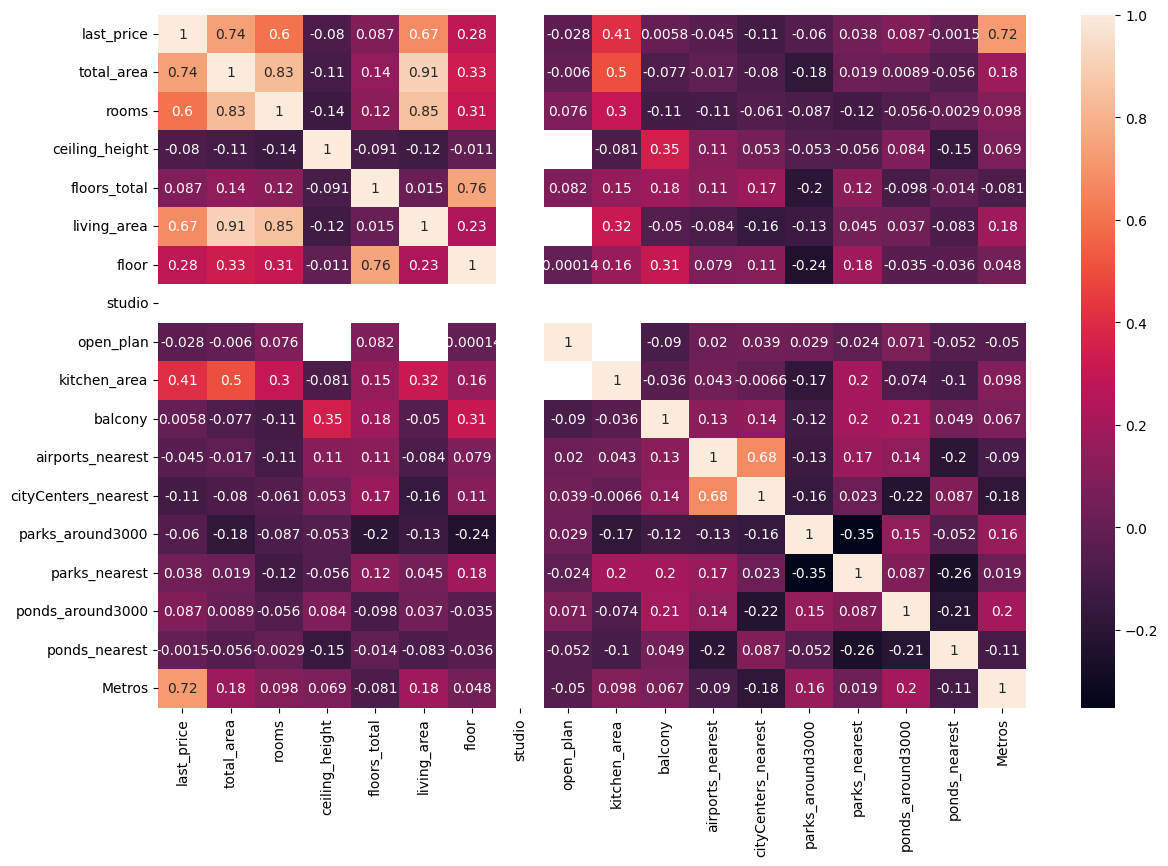

In [ ]:
plt.figure(figsize=(14,9))
sb.heatmap(df300000H.corr(),annot=True)

в диапазоне цена зависит от общей и жилой площади

<Axes: xlabel='last_price', ylabel='total_area'>

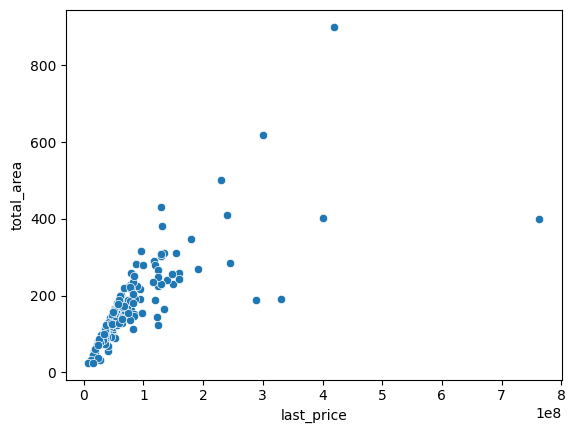

In [ ]:
sb.scatterplot (df300000H, x='last_price',y='total_area')


В диапазоне цена зависит от площади кухни

<Axes: xlabel='kitchen_area', ylabel='last_price'>

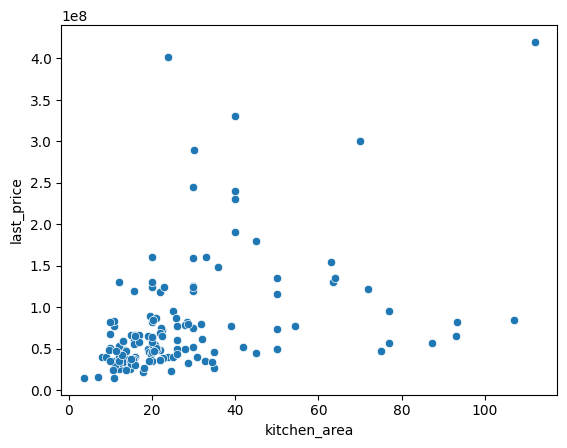

In [ ]:
sb.scatterplot (df300000H, x='kitchen_area',y='last_price')


Количество парков уменьшается в зависимости от роста этажности но уже меньше

<Axes: xlabel='parks_around3000', ylabel='floors_total'>

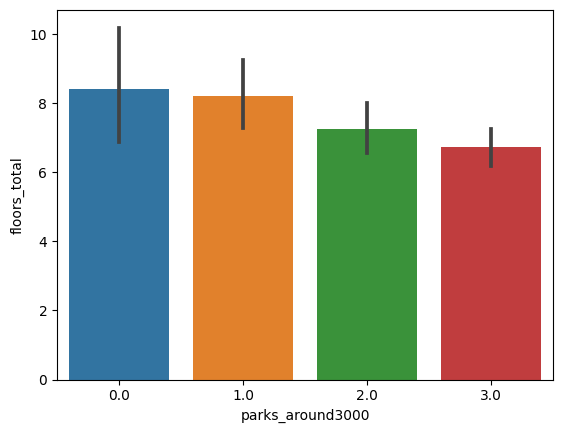

In [ ]:
sb.barplot (df300000H, x='parks_around3000',y='floors_total')


<Axes: xlabel='floor', ylabel='floors_total'>

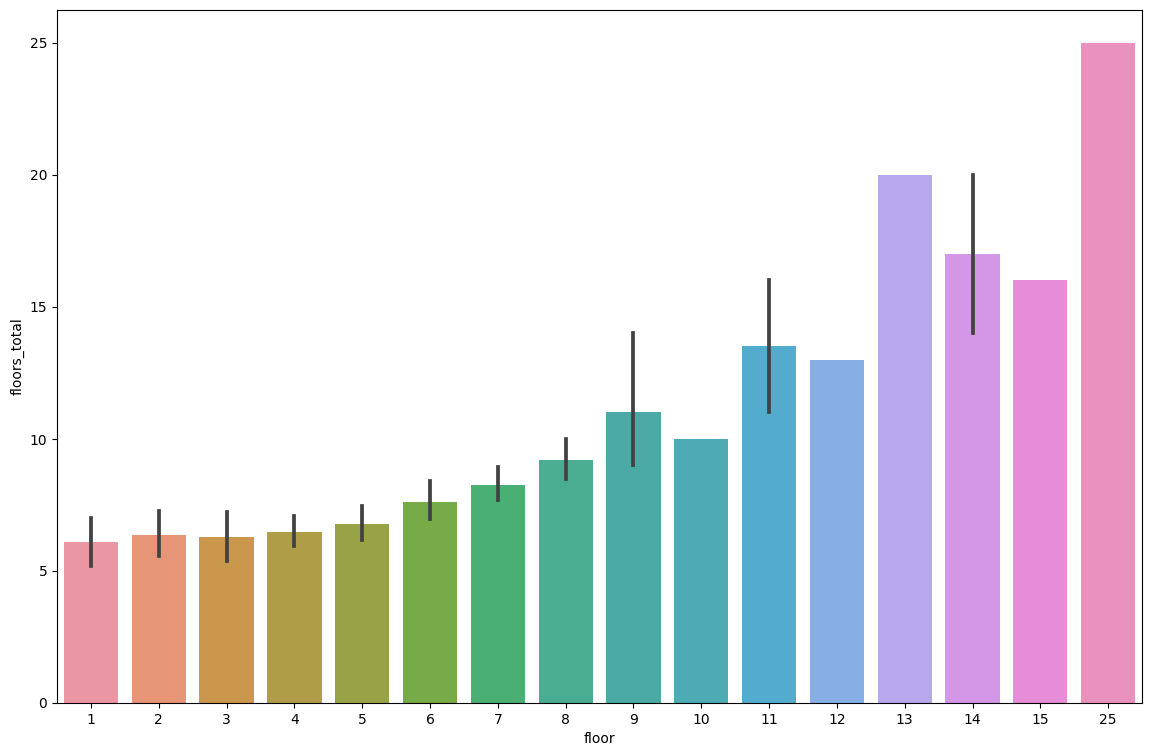

In [ ]:
plt.figure(figsize=(14,9))

sb.barplot (df300000H, x='floor',y='floors_total')

Квартир студий в диапазоне нет


<Axes: xlabel='studio', ylabel='last_price'>

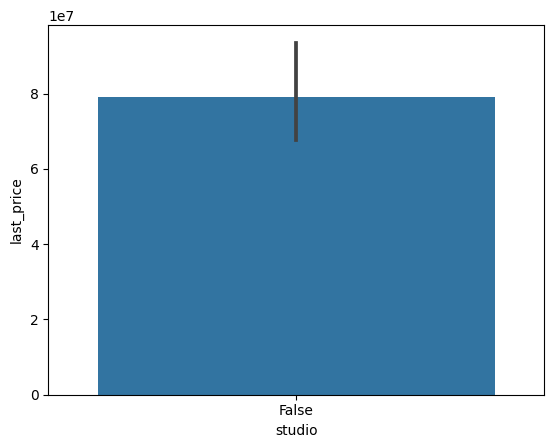

In [ ]:
sb.barplot (df300000H, x='studio',y='last_price')


Квартиры со свободной планировкой дешевле но их менее1%

<Axes: xlabel='open_plan', ylabel='last_price'>

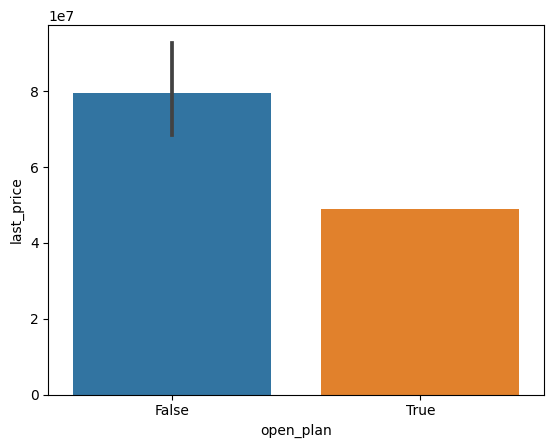

In [ ]:
sb.barplot (df300000H, x='open_plan',y='last_price')


In [ ]:
df300000H['open_plan'].value_counts(normalize=True)


False    0.994186
True     0.005814
Name: open_plan, dtype: float64

Далее анализ остальных параметров по когортам

C увеличением стоимости кв метра, уменьшается расстояние до центра

In [ ]:
df[(df['Metros']>300000)&(df['Metros'] < 1100000)]['cityCenters_nearest'].mean()


5003.634146341464

In [ ]:
df[(df['Metros']>114000)&(df['Metros'] < 300000)]['cityCenters_nearest'].mean()


10486.05390693591

In [ ]:
df[(df['Metros']>95000)&(df['Metros'] < 114000)]['cityCenters_nearest'].mean()


13572.170263788968

In [ ]:
df[(df['Metros']>77000)&(df['Metros'] < 95000)]['cityCenters_nearest'].mean()


16072.792276422764

In [ ]:
df[(df['Metros']>45000)&(df['Metros'] < 77000)]['cityCenters_nearest'].mean()


22976.862591431556

Колличество студийных квартир менее 1% и цена их в диапазоне от 945000 до 1630000

In [ ]:
df['studio'].value_counts(normalize=True)

False    0.993713
True     0.006287
Name: studio, dtype: float64

In [ ]:
df[df['studio'] == True]['last_price'].describe()

count    1.490000e+02
mean     3.070333e+06
std      1.572197e+06
min      9.457500e+05
25%      2.300000e+06
50%      2.750000e+06
75%      3.450000e+06
max      1.630000e+07
Name: last_price, dtype: float64

Колличество аппартаментов около 1% и цена их в диапазоне от 2150000 до 8400000

In [ ]:
df[df['is_apartment'] == True]['last_price'].describe()


count    5.000000e+01
mean     1.292420e+07
std      1.616967e+07
min      2.150000e+06
25%      4.815750e+06
50%      6.900000e+06
75%      1.246768e+07
max      8.400000e+07
Name: last_price, dtype: float64

In [ ]:
df['is_apartment'].value_counts(normalize=True)


False    0.981982
True     0.018018
Name: is_apartment, dtype: float64

В диапазоне цены кв метра до 300000 высота потолка приблизительно одинакова, после начинает существенно подниматься


In [ ]:
df[(df['Metros']>300000)&(df['Metros'] < 1100000)]['ceiling_height'].mean()


4.286831683168317

In [ ]:
df[(df['Metros']>114000)&(df['Metros'] < 300000)]['ceiling_height'].mean()


2.8815794898222107

In [ ]:
df[(df['Metros']>77000)&(df['Metros'] < 95000)]['ceiling_height'].mean()


2.6982095182820665

In [ ]:
df[(df['Metros']>45000)&(df['Metros'] < 77000)]['ceiling_height'].mean()


2.727659817351598

После цены 114000 зв кв метр расстояние до близжайшего водоема снижается

In [ ]:
df[(df['Metros']>45000)&(df['Metros'] < 77000)]['ponds_nearest'].mean()


514.0862068965517

In [ ]:
df[(df['Metros']>77000)&(df['Metros'] < 114000)]['ponds_nearest'].mean()



538.3690525444766

In [ ]:
df[(df['Metros']>114000)&(df['Metros'] < 300000)]['ponds_nearest'].mean()


495.9281681304893

In [ ]:
df[(df['Metros']>300000)&(df['Metros'] < 1100000)]['ponds_nearest'].mean()


353.9642857142857

После увеличения цены за кв метр более 300000 соотношение колличества водоемов резко изменяется в сторону наличия трех, до этого значения относительно постоянное соотношение.

In [ ]:
df[(df['Metros']>45000)&(df['Metros'] < 77000)]['ponds_around3000'].value_counts(normalize=True)


0.0    0.515152
1.0    0.303553
2.0    0.112853
3.0    0.068443
Name: ponds_around3000, dtype: float64

In [ ]:
df[(df['Metros']>300000)&(df['Metros'] < 1100000)]['ponds_around3000'].value_counts(normalize=True)


3.0    0.457317
1.0    0.207317
2.0    0.189024
0.0    0.146341
Name: ponds_around3000, dtype: float64

In [ ]:
df[(df['Metros']>95000)&(df['Metros'] < 300000)]['ponds_around3000'].value_counts(normalize=True)


0.0    0.484674
1.0    0.317124
2.0    0.107236
3.0    0.090966
Name: ponds_around3000, dtype: float64

После возрастания кв метра более 300000 расстояние до аэропорта незначительно, но сокращается, вполне возможна ложная корреляция

In [ ]:
df[(df['Metros']>300000)&(df['Metros'] < 1100000)]['airports_nearest'].mean()


26896.90243902439

In [ ]:
df[(df['Metros']>114000)&(df['Metros'] < 300000)]['airports_nearest'].mean()


28164.83618108156

In [ ]:
df[(df['Metros']>77000)&(df['Metros'] < 114000)]['airports_nearest'].mean()


29061.258801967782

In [ ]:
df[(df['Metros']>45000)&(df['Metros'] < 77000)]['airports_nearest'].mean()


29388.45920502092

Расстояние до близжайшего парка на цену влияет не значительно

In [ ]:
df[(df['Metros']>300000)&(df['Metros'] < 1100000)]['parks_nearest'].mean()


389.34090909090907

In [ ]:
df[(df['Metros']>45000)&(df['Metros'] < 77000)]['parks_nearest'].mean()


468.77666666666664

In [ ]:
df[(df['Metros']>114000)&(df['Metros'] < 300000)]['parks_nearest'].mean()


519.8911813643927

In [ ]:
sb.barplot(df[(df['Metros']>300000)&(df['Metros'] < 1100000)],x='balcony',y='last_price')


In [ ]:
sb.barplot(df[(df['Metros']>77000)&(df['Metros'] < 114000)],x='floors_total',y='balcony')


In [ ]:
sb.lineplot(x=df[(df['Metros']>300000)&(df['Metros'] < 1100000)])

In [ ]:
df[(df['Metros']>300000)&(df['Metros'] < 1100000)]['cityCenters_nearest']

In [ ]:
df[df['open_plan'] == True]['last_price'].describe()


count    6.700000e+01
mean     4.741851e+06
std      1.003273e+07
min      1.315000e+06
25%      2.345000e+06
50%      2.730000e+06
75%      3.525000e+06
max      7.100000e+07
Name: last_price, dtype: float64

Итак, если опистать ответ предложениями, цены на недвижимость, а также, что более важно, цена кв метра завист напрямую от ее общей и жилой площади, и как следствие с увеличением цены растет площадь кухни, далее, с увеличением цены растет номер выбираемого этажа и высотность здания, чем больше цена, тем ближе расстояние до центра, рост колличества балконов с ценой коррелируется слабо, как и с этажностью здания, при увеличении цены кв метра более 300000 колличество водоемов поблизости стремиться к трем, а расстояние до близжайшего аэропорта немного уменьшается, при увеличении колличества парков уменьшается этажность здания, из отдельных проектов самые дорогие - аппартаменты, самые дешевые - студии, однако их колличество незначительное, между ними находятся квартиры с открытой планировкой.

Если описать этот сет какой либо полезной функцией, то на мой взгляд она должна принимать источник данных, значение стоимости и колличество похожих значений, а возвращать таблицу со всеми похожими значениями в рамках заданного интелвала, то есть, покупатель имея определенную сумму для покупки недвижимости введя ее в условия фукции, может получить таблицу того, что он может купить за свои деньги со всеми параметрами

In [ ]:
def Findobjekt(df=DataFrame,a=float,n=int):
  dfchek = df.iloc[(df['last_price']-a).abs().argsort()[:n]]
  return dfchek

In [ ]:
Findobjekt(df,478090,5)

,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest
16032,480000.0,32.0,1,NaN,2.0,16.0,1,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21912,470000.0,37.0,1,NaN,3.0,NaN,3,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18867,470000.0,41.0,1,NaN,5.0,32.0,3,NaN,False,False,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23484,470000.0,44.5,2,NaN,2.0,28.0,2,NaN,False,False,7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10782,490000.0,29.1,1,2.5,5.0,17.0,5,NaN,False,False,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Функция принимает(источник данных, жилую площадь, площадь кухни, расстояние до центра, этаж)
Возвращает орентировочную стоимость квартиры

In [ ]:
def Objekt(df=DataFrame,a=float,b=float,c=float,d=float,e=float):
  dfchek = df.iloc[(df['total_area']-a).abs().argsort()[:10]]
  dftot = dfchek.iloc[(dfchek['living_area']-b).abs().argsort()[:(5)]]
  dfkit = dftot.iloc[(dftot['kitchen_area']-c).abs().argsort()[:4]]
  dfcit = dfkit.iloc[(dfkit['cityCenters_nearest']-d).abs().argsort()[:3]]
  dffl= dfcit.iloc[(dfcit['floor']-e).abs().argsort()[:2]]

  print('Орентировочная стоимость')
  return dffl['last_price'].mean()

In [ ]:
Objekt(df,130,32,25,18800,8)

Орентировочная стоимость


15950000.0